In [1]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/fruits_dataset.tar.gz

--2024-07-15 12:20:21--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/fruits_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 3.5.30.214, 52.216.92.251, 16.182.68.209, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|3.5.30.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361408056 (345M) [application/x-gzip]
Saving to: ‘fruits_dataset.tar.gz’

fruits_dataset.tar. 100%[===================>] 344.67M  18.1MB/s    in 21s     

2024-07-15 12:20:43 (16.4 MB/s) - ‘fruits_dataset.tar.gz’ saved [361408056/361408056]



In [2]:
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

# Use it like this:
extract_tar_gz('/content/fruits_dataset.tar.gz', '/content/')

In [3]:
import tensorflow as tf


In [4]:
train_set = tf.keras.utils.image_dataset_from_directory(
        directory='/content/fruits/train',
        labels='inferred',
        label_mode='categorical',
        batch_size=256,
        image_size=(100,100),
        validation_split=0.25,
        subset="training",
        seed=417)
validation_set = tf.keras.utils.image_dataset_from_directory(
        directory='/content/fruits/train',
        labels='inferred',
        label_mode='categorical',
        batch_size=256,
        image_size=(100,100),
        validation_split=0.25,
        subset="validation",
        seed=417)
test_set =tf.keras.utils.image_dataset_from_directory(
        directory='/content/fruits/test',
        labels='inferred',
        label_mode='categorical',
        batch_size=256,
        image_size=(100,100),
        seed=417)


Found 67692 files belonging to 131 classes.
Using 50769 files for training.
Found 67692 files belonging to 131 classes.
Using 16923 files for validation.
Found 22688 files belonging to 131 classes.


In [5]:
%matplotlib inline
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [6]:
normalization_layer=tf.keras.layers.Rescaling(scale=1./255)

train_set_normalized=train_set.map(lambda imgs,labels: (normalization_layer(imgs),labels))
validation_set_normalized=validation_set.map(lambda imgs,labels: (normalization_layer(imgs),labels))
test_set_normalized=test_set.map(lambda imgs,labels: (normalization_layer(imgs),labels))



In [7]:
train_set_elem=train_set_normalized.take(1)

for images, labels in train_set_elem:
  labels=labels
  images=images
  im=images.numpy()
  break



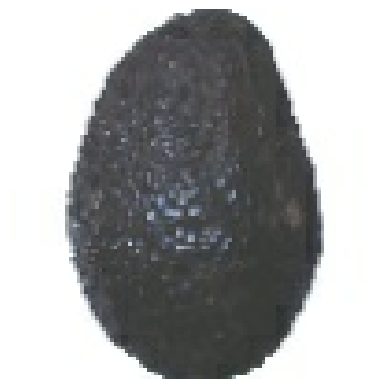

In [8]:
plt.imshow(im[0])
plt.axis('off')
plt.show()

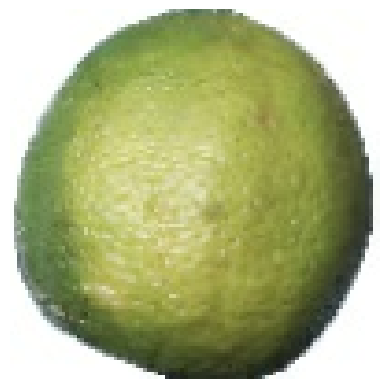

In [9]:
plt.imshow(im[1])
plt.axis('off')
plt.show()

In [10]:
from tensorflow.keras import initializers


In [11]:
weight_initializer=initializers.HeNormal(seed=417)

In [12]:
def resnet_block(input_layer, num_filters):
  shortcut=input_layer
  output=layers.Conv2D(num_filters, (3,3), padding='same', strides=1, kernel_initializer=weight_initializer)(input_layer)
  output=layers.BatchNormalization()(output)
  output=layers.Activation('relu')(output)
  output=layers.Conv2D(num_filters, (3,3), padding='same', strides=1, kernel_initializer=weight_initializer)(output)
  output=layers.BatchNormalization()(output)
  output=layers.Add()([output,shortcut])
  output=layers.Activation('relu')(output)
  return output


In [13]:
from tensorflow.keras import models, Input


In [14]:
def resnet18(num_classes):
  input_layer=Input(shape=(100,100, 3))
  conv=layers.Conv2D(64, (7,7), padding='same', strides=2, kernel_initializer=weight_initializer)(input_layer)
  conv=layers.BatchNormalization()(conv)
  conv=layers.Activation('relu')(conv)
  conv=layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(conv)
  block1=resnet_block(conv, 64)
  block2=resnet_block(block1, 64)
  global_pooling=layers.GlobalAveragePooling2D()(block2)
  output=layers.Dense(num_classes)(global_pooling)
  model=models.Model(inputs=input_layer, outputs=output)
  return model


In [15]:
model=resnet18(131)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 50, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 50, 50, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 50, 50, 64)           0         ['batch_normalization[0][0

In [16]:
# def resnet18(num_classes):
#   input_layer=Input(shape=(100,100, 3))
#   conv=layers.Conv2D(64, (7,7), padding='same', strides=2, kernel_initializer=weight_initializer)(input_layer)
#   conv=layers.BatchNormalization()(conv)
#   conv=layers.Activation('relu')(conv)
#   conv=layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(conv)
#   block1=resnet_block(conv, 64)
#   block2=resnet_block(block1, 64)
#   block3=resnet_block(block2, 128)
#   block4=resnet_block(block3, 128)
#   global_pooling=layers.GlobalAveragePooling2D()(block4)
#   output=layers.Dense(num_classes)(global_pooling)
#   model=models.Model(inputs=input_layer, outputs=output)
#   return model

# model=resnet18(131)
# model.summary()

In [17]:
# # New
# def resnet_block(input_layer, num_filters, downsample=False):
#   if downsample==True:
#     stride=2
#     shortcut=layers.Conv2D(num_filters, (1,1), padding='same', strides=stride, kernel_initializer=weight_initializer)(input_layer)
#     shortcut=layers.BatchNormalization()(shortcut)
#   else:
#     stride=1
#     shortcut=input_layer
#   strides=stride
#   output=layers.Conv2D(num_filters, (3,3), padding='same', strides=stride, kernel_initializer=weight_initializer)(input_layer)
#   output=layers.BatchNormalization()(output)
#   output=layers.Activation('relu')(output)
#   output=layers.Conv2D(num_filters, (3,3), padding='same', strides=stride, kernel_initializer=weight_initializer)(output)
#   output=layers.BatchNormalization()(output)
#   output=layers.Add()([output,shortcut])
#   output=layers.Activation('relu')(output)
#   return output


In [18]:
def resnet_block(input_layer, num_filters, downsample=False):
    stride = 2 if downsample else 1

    if downsample:
        shortcut = layers.Conv2D(num_filters, (1, 1), padding='same', strides=stride, kernel_initializer=weight_initializer)(input_layer)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_layer

    output = layers.Conv2D(num_filters, (3, 3), padding='same', strides=stride, kernel_initializer=weight_initializer)(input_layer)
    output = layers.BatchNormalization()(output)
    output = layers.Activation('relu')(output)
    output = layers.Conv2D(num_filters, (3, 3), padding='same', strides=1, kernel_initializer=weight_initializer)(output)
    output = layers.BatchNormalization()(output)

    output = layers.Add()([output, shortcut])
    output = layers.Activation('relu')(output)
    return output

In [19]:
def resnet18(num_classes):
  input_layer=Input(shape=(100,100, 3))
  conv=layers.Conv2D(64, (7,7), padding='same', strides=2, kernel_initializer=weight_initializer)(input_layer)
  conv=layers.BatchNormalization()(conv)
  conv=layers.Activation('relu')(conv)
  conv=layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(conv)
  block1=resnet_block(conv, 64)
  block2=resnet_block(block1, 64)
  block3=resnet_block(block2, 128, downsample=True)
  block4=resnet_block(block3, 128)
  block5=resnet_block(block4, 256, downsample=True)
  block6=resnet_block(block5, 256)
  block7=resnet_block(block6, 512, downsample=True)
  block8=resnet_block(block7, 512)
  global_pooling=layers.GlobalAveragePooling2D()(block8)
  output=layers.Dense(num_classes)(global_pooling)
  model=models.Model(inputs=input_layer, outputs=output)
  return model

model=resnet18(131)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 50, 50, 64)           9472      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_5 (Bat  (None, 50, 50, 64)           256       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_5 (Activation)   (None, 50, 50, 64)           0         ['batch_normalization_5[

In [20]:
opt=tf.keras.optimizers.SGD(learning_rate=0.001)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])


In [27]:
model.fit(train_set_normalized, validation_data=validation_set_normalized, epochs=5)

Epoch 1/5
199/199 [==============================] - 57s 283ms/step - loss: 0.9181 - accuracy: 0.9387 - val_loss: 0.8598 - val_accuracy: 0.9421
Epoch 2/5
199/199 [==============================] - 49s 247ms/step - loss: 0.8347 - accuracy: 0.9459 - val_loss: 0.7828 - val_accuracy: 0.9485
Epoch 3/5
199/199 [==============================] - 51s 252ms/step - loss: 0.7626 - accuracy: 0.9520 - val_loss: 0.7156 - val_accuracy: 0.9541
Epoch 4/5
199/199 [==============================] - 56s 279ms/step - loss: 0.6973 - accuracy: 0.9574 - val_loss: 0.6568 - val_accuracy: 0.9583
Epoch 5/5
199/199 [==============================] - 49s 246ms/step - loss: 0.6401 - accuracy: 0.9618 - val_loss: 0.6016 - val_accuracy: 0.9620


In [29]:
test_loss, test_acc=model.evaluate(test_set_normalized)


89/89 [==============================] - 7s 79ms/step - loss: 0.9517 - accuracy: 0.8684
